# Imports

In [1]:
import importlib
import json
import math
from itertools import islice
from pathlib import Path
from typing import Callable

import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from n2g import NeuronStats
from transformer_lens import HookedTransformer

import thesis

importlib.reload(thesis)
from thesis.device import Device
from thesis.mas import MASStore, html

# Methods

In [2]:
def sorted(x):
    sorted_x = x.copy()
    sorted_x.sort()
    return sorted_x


def bootstrap_metric_std(x: np.ndarray, metric: Callable[[np.ndarray], np.ndarray], num_samples: int) -> float:
    samples = np.random.choice(x, (num_samples, x.size), replace=True)
    means = metric(samples)
    std = means.std()
    return metric(x), std


def bootstrap_mean_std(x: np.ndarray, num_samples: int) -> tuple[float, float]:
    return bootstrap_metric_std(x, lambda x: x.mean(axis=-1), num_samples)


def bootstrap_min_std(x: np.ndarray, num_samples: int) -> tuple[float, float]:
    return bootstrap_metric_std(x, lambda x: x.min(axis=-1), num_samples)


def bootstrap_test(x: np.ndarray, y: np.ndarray, num_samples: int) -> float:
    x_mean = x.mean()
    y_mean = y.mean()
    t = (x_mean - y_mean) / math.sqrt(x.var() / x.size + y.var() / y.size)
    z = (x.sum() + y.sum()) / (x.size + y.size)
    x_prime = x - x_mean + z
    y_prime = y - y_mean + z
    samples_x = np.random.choice(x_prime, (num_samples, x.size), replace=True)
    samples_y = np.random.choice(y_prime, (num_samples, y.size), replace=True)
    x_means = samples_x.mean(axis=1)
    y_means = samples_y.mean(axis=1)
    x_vars = samples_x.var(axis=1)
    y_vars = samples_y.var(axis=1)
    t_samples = (x_means - y_means) / np.sqrt(x_vars / x.size + y_vars / y.size)
    return (t_samples >= t).mean()

# Data

In [3]:
N_MLP = 2048
N_SAE = 2048 * 8
N_BOOTSTRAP = 1000

outputs_path = Path("outputs")
mlp_path = outputs_path / "mlp_stats.json"
sae_path = outputs_path / "sae_stats.json"

with mlp_path.open("r", encoding="utf-8") as f:
    mlp_stats_json = json.load(f)
    mlp_stats = [NeuronStats.from_dict(neuron_stats) for neuron_stats in mlp_stats_json["0"].values()]

with sae_path.open("r", encoding="utf-8") as f:
    sae_stats_json = json.load(f)
    sae_stats = [NeuronStats.from_dict(neuron_stats) for neuron_stats in sae_stats_json]

assert len(mlp_stats) == N_MLP
assert len(sae_stats) == N_SAE

In [4]:
def get_stats(neuron_stats: list[NeuronStats], get: Callable[[NeuronStats], float]) -> list[float]:
    return [get(neuron) for neuron in neuron_stats]


def stats_df(stats: list[NeuronStats], group: str) -> pd.DataFrame:
    return pd.DataFrame(
        {
            "accuracy": get_stats(stats, lambda x: x.accuracy),
            "firing_recall": get_stats(stats, lambda x: x.firing.recall),
            "firing_precision": get_stats(stats, lambda x: x.firing.precision),
            "firing_f1": get_stats(stats, lambda x: x.firing.f1_score),
            "firing_count": get_stats(stats, lambda x: x.firing.count),
            "non_firing_recall": get_stats(stats, lambda x: x.non_firing.recall),
            "non_firing_precision": get_stats(stats, lambda x: x.non_firing.precision),
            "non_firing_f1": get_stats(stats, lambda x: x.non_firing.f1_score),
            "non_firing_count": get_stats(stats, lambda x: x.non_firing.count),
            "group": [group] * len(stats),
        }
    )


mlp_df = stats_df(mlp_stats, "mlp")
sae_df = stats_df(sae_stats, "sae")

df = pd.concat([mlp_df, sae_df])

In [5]:
mlp_firing_recall = mlp_df["firing_recall"].to_numpy()
sae_firing_recall = sae_df["firing_recall"].to_numpy()

mlp_firing_precision = mlp_df["firing_precision"].to_numpy()
sae_firing_precision = sae_df["firing_precision"].to_numpy()

mlp_firing_f1_score = mlp_df["firing_f1"].to_numpy()
sae_firing_f1_score = sae_df["firing_f1"].to_numpy()

# NaN and means

In [6]:
mlp_nan_ratio = mlp_firing_f1_score[np.isnan(mlp_firing_f1_score)].size / mlp_firing_f1_score.size
sae_nan_ratio = sae_firing_f1_score[np.isnan(sae_firing_f1_score)].size / sae_firing_f1_score.size

mlp_firing_recall_mean = mlp_firing_recall.mean()
sae_firing_recall_mean = sae_firing_recall.mean()

mlp_firing_precision_mean = mlp_firing_precision[~np.isnan(mlp_firing_precision)].mean()
sae_firing_precision_mean = sae_firing_precision[~np.isnan(sae_firing_precision)].mean()

mlp_firing_f1_score_mean = mlp_firing_f1_score[~np.isnan(mlp_firing_f1_score)].mean()
sae_firing_f1_score_mean = sae_firing_f1_score[~np.isnan(sae_firing_f1_score)].mean()

print(f"MLP nan ratio: {mlp_nan_ratio}")
print(f"SAE nan ratio: {sae_nan_ratio}")
print()
print(f"MLP firing recall mean: {mlp_firing_recall_mean}")
print(f"SAE firing recall mean: {sae_firing_recall_mean}")
print()
print(f"MLP firing precision mean: {mlp_firing_precision_mean}")
print(f"SAE firing precision mean: {sae_firing_precision_mean}")
print()
print(f"MLP firing F1 score mean: {mlp_firing_f1_score_mean}")
print(f"SAE firing F1 score mean: {sae_firing_f1_score_mean}")

MLP nan ratio: 0.00341796875
SAE nan ratio: 0.584716796875

MLP firing recall mean: 0.38197167938360255
SAE firing recall mean: 0.3119768385602392

MLP firing precision mean: 0.3513902233222108
SAE firing precision mean: 0.7328919709489895

MLP firing F1 score mean: 0.28882687914164107
SAE firing F1 score mean: 0.6871083182717397


# Plots

In [7]:
counts = {"mlp": N_MLP, "sae": N_SAE}
notnull_counts = {
    "mlp": (1 - mlp_nan_ratio) * N_MLP,
    "sae": (1 - sae_nan_ratio) * N_SAE,
}
notnull_df = df[df["firing_precision"].notnull()]

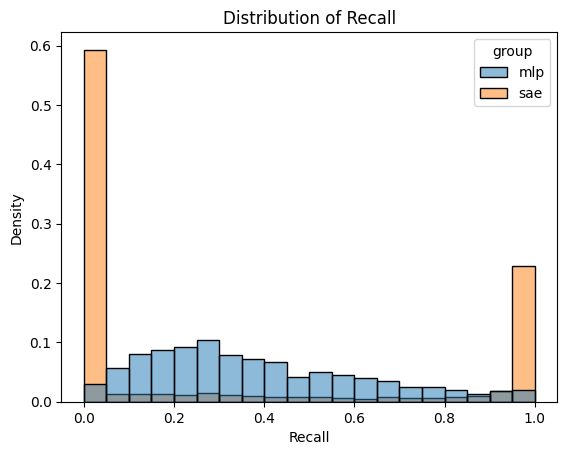

In [8]:
sns.histplot(data=df, x="firing_recall", hue="group", bins=20, weights=1 / df["group"].map(counts))
plt.xlabel("Recall")
plt.ylabel("Density")
plt.title("Distribution of Recall")
plt.show()

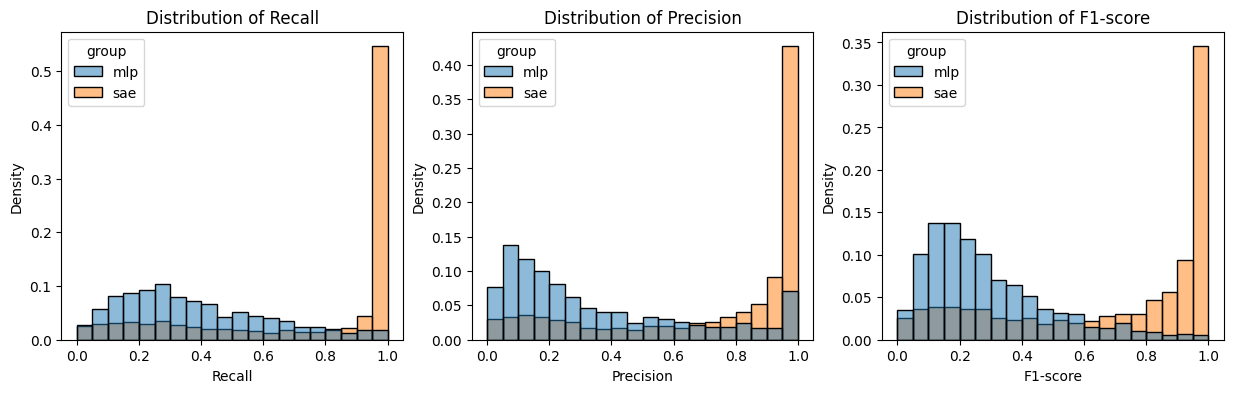

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

plot_info = [("firing_recall", "Recall"), ("firing_precision", "Precision"), ("firing_f1", "F1-score")]
for ax, (column, title) in zip(axes, plot_info, strict=True):
    sns.histplot(
        data=notnull_df, x=column, hue="group", bins=20, weights=1 / notnull_df["group"].map(notnull_counts), ax=ax
    )
    ax.set_xlabel(title)
    ax.set_ylabel("Density")
    ax.set_title(f"Distribution of {title}")


plt.show()

# Tests
Only done on roughly the best half of each set of features due to issues with NaN's

In [10]:
MLP_START_INDEX = -int(math.ceil((1 - sae_nan_ratio) * N_MLP))
SAE_START_INDEX = -int(math.ceil((1 - sae_nan_ratio) * N_SAE))
best_mlp_firing_recall = sorted(mlp_firing_recall)[MLP_START_INDEX:]
best_sae_firing_recall = sorted(sae_firing_recall)[SAE_START_INDEX:]
mlp_recall_mean, mlp_recall_mean_std = bootstrap_mean_std(best_mlp_firing_recall, N_BOOTSTRAP)
sae_recall_mean, sae_recall_mean_std = bootstrap_mean_std(best_sae_firing_recall, N_BOOTSTRAP)
print(f"MLP firing recall mean: {mlp_recall_mean}   std: {mlp_recall_mean_std}")
print(f"SAE firing recall mean: {sae_recall_mean}   std: {sae_recall_mean_std}")
recall_stds = abs(mlp_recall_mean - sae_recall_mean) / (mlp_recall_mean_std + sae_recall_mean_std)
recall_chebychev_p = 1 / (recall_stds**2)
recall_bootstrap_p = bootstrap_test(best_mlp_firing_recall, best_sae_firing_recall, N_BOOTSTRAP)
print(f"stds: {recall_stds:10.2f}    chebychev p: {recall_chebychev_p:10.4f}")
print(f"p-value: {recall_bootstrap_p:10.4f}")
print()

best_mlp_firing_precision = sorted(mlp_firing_precision[~np.isnan(mlp_firing_precision)])[MLP_START_INDEX:]
best_sae_firing_precision = sorted(sae_firing_precision[~np.isnan(sae_firing_precision)])[SAE_START_INDEX:]
mlp_precision_mean, mlp_precision_mean_std = bootstrap_mean_std(best_mlp_firing_precision, N_BOOTSTRAP)
sae_precision_mean, sae_precision_mean_std = bootstrap_mean_std(best_sae_firing_precision, N_BOOTSTRAP)
print(f"MLP firing precision mean: " f"{mlp_precision_mean}   std: {mlp_precision_mean_std}")
print(f"SAE firing precision mean: " f"{sae_precision_mean}   std: {sae_precision_mean_std}")
precision_stds = abs(mlp_precision_mean - sae_precision_mean) / (mlp_precision_mean_std + sae_precision_mean_std)
precision_chebychev_p = 1 / (precision_stds**2)
precision_bootstrap_p = bootstrap_test(best_mlp_firing_precision, best_sae_firing_precision, N_BOOTSTRAP)
print(f"stds: {precision_stds:10.2f}    chebychev p: {precision_chebychev_p:10.4f}")
print(f"p-value: {precision_bootstrap_p:10.4f}")
print()

best_mlp_firing_f1_score = sorted(mlp_firing_f1_score[~np.isnan(mlp_firing_f1_score)])[MLP_START_INDEX:]
best_sae_firing_f1_score = sorted(sae_firing_f1_score[~np.isnan(sae_firing_f1_score)])[SAE_START_INDEX:]
mlp_f1_score_mean, mlp_f1_score_mean_std = bootstrap_mean_std(best_mlp_firing_f1_score, N_BOOTSTRAP)
sae_f1_score_mean, sae_f1_score_mean_std = bootstrap_mean_std(best_sae_firing_f1_score, N_BOOTSTRAP)
print(f"MLP firing F1 score mean: {mlp_f1_score_mean}   std: {mlp_f1_score_mean_std}")
print(f"SAE firing F1 score mean: {sae_f1_score_mean}   std: {sae_f1_score_mean_std}")
f1_score_stds = abs(mlp_f1_score_mean - sae_f1_score_mean) / (mlp_f1_score_mean_std + sae_f1_score_mean_std)
f1_score_chebychev_p = 1 / (f1_score_stds**2)
f1_score_bootstrap_p = bootstrap_test(best_mlp_firing_f1_score, best_sae_firing_f1_score, N_BOOTSTRAP)
print(f"stds: {f1_score_stds:10.2f}    chebychev p: {f1_score_chebychev_p:10.4f}")
print(f"p-value: {f1_score_bootstrap_p:10.4f}")

MLP firing recall mean: 0.6167556243048715   std: 0.006122307708227268
SAE firing recall mean: 0.7512387599898531   std: 0.0038663302957180367
stds:      13.46    chebychev p:     0.0055
p-value:     1.0000

MLP firing precision mean: 0.6451283300838674   std: 0.00811961689225311
SAE firing precision mean: 0.7328919709489894   std: 0.004099701980290229
stds:       7.18    chebychev p:     0.0194
p-value:     1.0000

MLP firing F1 score mean: 0.4749241027188639   std: 0.0058374121814324985
SAE firing F1 score mean: 0.6871083182717397   std: 0.0040488933145229515
stds:      21.46    chebychev p:     0.0022
p-value:     1.0000


# Investigation

In [11]:
device = Device.get()

sae_mas_store = MASStore.load(outputs_path / "gelu-1l-sae_store.zip", device)

model: HookedTransformer = HookedTransformer.from_pretrained("gelu-1l", device=device.torch())  # type: ignore[reportUnknownVariableType]

Loaded pretrained model gelu-1l into HookedTransformer


In [12]:
# Skip the first 2048 features since they are MLP features.
mas_samples = sae_mas_store.feature_samples()[2048:]
mas_activations = sae_mas_store.feature_activations()[2048:]

nan_features = sae_df.index[sae_df["firing_f1"].isnull()]
perfect_features = sae_df.index[sae_df["firing_f1"] == 1]
print(f"Number of NaN features: {nan_features.size}")
print(f"Number of perfect features: {perfect_features.size}")

num_samples = 10
graph_dir = outputs_path / "gelu-1l-sae"

nan_dir = outputs_path / "nan_samples"
nan_dir.mkdir(exist_ok=True, parents=True)
for index in islice(nan_features, num_samples):
    graph_file = graph_dir / f"{index}"
    graph = graphviz.Source.from_file(graph_file)
    html_str = html.generate_html(model, mas_samples[index], mas_activations[index], n2g_source=graph)
    with (nan_dir / f"{index}.html").open("w", encoding="utf-8") as f:
        f.write(html_str)


perfect_dir = outputs_path / "perfect_samples"
perfect_dir.mkdir(exist_ok=True, parents=True)
for index in islice(perfect_features, num_samples):
    graph_file = graph_dir / f"{index}"
    graph = graphviz.Source.from_file(graph_file)
    html_str = html.generate_html(model, mas_samples[index], mas_activations[index], n2g_source=graph)
    print(
        f"Feature {index} has {sae_df.loc[index, 'firing_count']} firing tokens and "
        f"{sae_df.loc[index, 'non_firing_count']} non-firing tokens."
    )
    with (perfect_dir / f"{index}.html").open("w", encoding="utf-8") as f:
        f.write(html_str)

Number of NaN features: 9580
Number of perfect features: 1342
Feature 27 has 22 firing tokens and 4074 non-firing tokens.
Feature 38 has 20 firing tokens and 4076 non-firing tokens.
Feature 50 has 18 firing tokens and 4094 non-firing tokens.
Feature 63 has 20 firing tokens and 4076 non-firing tokens.
Feature 67 has 17 firing tokens and 4079 non-firing tokens.
Feature 116 has 23 firing tokens and 4073 non-firing tokens.
Feature 127 has 30 firing tokens and 4066 non-firing tokens.
Feature 128 has 21 firing tokens and 4075 non-firing tokens.
Feature 143 has 40 firing tokens and 4056 non-firing tokens.
Feature 147 has 21 firing tokens and 4075 non-firing tokens.
